# Assessment for Advanced Data Science

## Christian Cabrera, Radzim Sendyka, Carl Henrik Ek and Neil D. Lawrence

### 6th November 2023



Welcome to the course assessment for the Advanced Data Science unit. In this assessment you will build a prediction system for UK house prices.

Your prediction system will be based on data from the UK Price Paid data available [here](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). By combining this data with the UK Office for National Statistics data on the latitude/longitude of postcodes (available [here](https://www.getthedata.com/open-postcode-geo)) you will have a record of house prices and their approximate latitude/longitude. Due to the size of these data you will use a relational database to handle them.  

To make predictions of the house price you will augment your data with information obtained from Open Street Map: an open license source of mapping information. You will use the techniques you have learnt in the course to indentify and incorporate useful features for house price prediction.



Alongside your implementation you will provide a short repository overview describing how you have implemented the different parts of the project and where you have placed those parts in your code repository. You will submit your code alongside a version of this notebook that will allow your examiner to understand and reconstruct the thinking behind your analysis. This notebook is structured to help you in creating that description and allow you to understand how we will allocate the marks. You should make use of the Fynesse framework (<https://github.com/lawrennd/fynesse_template>) for structuring your code.

Remember the notebook you create should *tell a story*, any code that is not critical to that story can safely be placed into the associated analysis library and imported for use (structured as given in the Fynesse template)

The maximum total mark for this assessment is 20. That mark is split into Three Questions below, each worth 5 marks each. Then a final 5 marks will be given for the quality, structure and reusability of the code and analysis you produce giving 20 marks in total. At the end, we would like to know your experience using LLMs in this assignment.

### Important Note:

*Some tasks in this assignment require you to develop skills for searching for multiple solutions and trying different things. This environment recreates industrial data science and software engineering problems. There is no one right answer.*


### Useful Links

You may find some of the following links useful when building your system.

University instuctions on Security and Privacy with AWS.

https://help.uis.cam.ac.uk/service/network-services/hosting-services/AWS/aws-security-privacy

Security Rules in AWS

https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_VPC.Scenarios.html#USER_VPC.Scenario4

### Installing Your Library

One artefact to be included in your submission is a python library structured according to the "Access, Assess, Address" standard for data science solutions. You will submit this library alongside your code. Use the cell below to perform the necessary installation instructions for your library.

You should base your module on the template repository given by the Fynesse template repository. That should make it `pip` installable as below.



In [1]:
# Install your library here, for example the fynesse template is set up to be pip installable
%pip install git+https://github.com/StefanPitur/advds.git

  Cloning https://github.com/StefanPitur/advds.git to /private/var/folders/zw/k_yg06y900n5xjbfnsrj3mlw0000gn/T/pip-req-build-yxjrphti
  Running command git clone --filter=blob:none --quiet https://github.com/StefanPitur/advds.git /private/var/folders/zw/k_yg06y900n5xjbfnsrj3mlw0000gn/T/pip-req-build-yxjrphti
  Resolved https://github.com/StefanPitur/advds.git to commit 6e370c81a8712bfc8829178e1048c8a905a3a064
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


Your own library should be installed in the line above, then you can import it as usual (where you can either replace `fynesse` with the name you've given your analysis module or you can leave the name as `fynesse` as you prefer).

In [2]:
from fynesse import *

ImportError: cannot import name 'access' from 'fynesse.access' (/Users/pitur/Work/part2/ads/advds/fynesse/access.py)

## Question 1. Accessing a Database of House Prices, Latitudes and Longitudes

The UK price paid data for housing dates back to 1995 and contains millions of transactions. The size of the data makes it unwieldy to manipulate directly in python frameworks such as `pandas`. As a result we will host the data in a *relational database*.

Using the following ideas.

1. A cloud hosted database (such as MariaDB hosted on the AWS RDS service).
2. The SQL language wrapped in appropriately structured python code.
3. Joining of two databases.

You will construct a database containing tables that contain all house prices, latitudes and longitudes from the UK house price data base since 1995.

You will likely find the following resources helpful.

1. Lecture 1, 2 and 3.
2. Lab class 1 and 2.
3. The UK Price Paid data for houses: <https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads>
4. The UK ONS Data base of postcode latitude and longitudes:  <https://www.getthedata.com/open-postcode-geo>

Below we provide codeboxes and hints to help you develop your answer.

### Important Notes:

*The main knowledge you need to do a first pass through this question will have been taught by the end of Lab Session 2 (31st October 2023). You will likely want to review your answer as part of **refactoring** your code  and analysis pipeline shortly before hand in.*

*We recommend doing Question 1 as early as possible to avoid being blocked from important work given that uploading the data can take long.*

*If you encounter problems with the online notebook (e.g., interrupted connections with the AWS server), you can use a local IDE to work in your machine.*

*5 Marks*

In [173]:
import pymysql
import osmnx as ox
import pandas as pd

config = {
    "default_tags": {
        "amenity": ["school", "restaurant"],
        "leisure": True,
        "healthcare":True,
        "shop": True,
        "public_transport": True
    },
    "default_tags_list": ["school", "restaurant", "leisure", "healthcare", "shop", "public_transport"],
    "default_bounding_box": 0.1,
    "default_category_distance_boundaries": {
        "walking_distance": 0.5,
        "cycling_distance": 5,
        "driving_distance": 10
    },
    "default_training_size": 0.8
}

class PropertyPricesDbConnector:
    _conn = None

    def __init__(self, host, port, username, password):
        self._host = host
        self._port = port
        self._username = username
        self._password = password
        self._database = "property_prices"

        try:
            self._create_database()
            self._create_connection_to_database()
        except DatabaseCreationException as database_creation_exception:
            raise Exception(database_creation_exception)
        except DatabaseConnectionException as database_connection_exception:
            raise Exception(database_connection_exception)

    def _create_database(self):
        try:
            conn = pymysql.connect(
                host=self._host,
                port=self._port,
                user=self._username,
                password=self._password
            )
            conn.cursor().execute(f"CREATE DATABASE IF NOT EXISTS {self._database}")
        except Exception as e:
            raise DatabaseCreationException(f"Could not create a new database at the give server! - {e}")

    def _create_connection_to_database(self):
        """
            Create connection to the MariaDB instance on AWS by using the host url, port, credentials and database name.
        """
        try:
            self._conn = pymysql.connect(
                host=self._host,
                port=self._port,
                user=self._username,
                password=self._password,
                database=self._database,
                local_infile=1
            )
        except Exception as e:
            raise DatabaseConnectionException(f"Could not establish connection to the database server! - {e}")

    def get_conn(self):
        return self._conn



class DatabaseCreationException(Exception):
    def __init__(self, message):
        super().__init__(message)


class DatabaseConnectionException(Exception):
    def __init__(self, message):
        super().__init__(message)


def create_property_prices_database(host, port, username, password):
    conn = pymysql.connect(
        host=host,
        port=port,
        user=username,
        password=password
    )
    conn.cursor().execute("CREATE DATABASE IF NOT EXISTS `property_prices`")


def create_property_prices_db_connection(host, port, username, password):
    conn = pymysql.connect(
        host=host,
        port=port,
        user=username,
        password=password,
        database="property_prices",
        local_infile=1
    )
    return conn


def create_and_populate_pp_data_table(conn):
    create_pp_data_table(conn)
    populate_pp_data_table(conn)


def create_pp_data_table(conn):
    conn.cursor().execute("""
        -- Table structure for table `pp_data`
        DROP TABLE IF EXISTS `pp_data`;
    """)
    conn.cursor().execute("""
        CREATE TABLE IF NOT EXISTS `pp_data` (
          `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
          `price` int(10) unsigned NOT NULL,
          `date_of_transfer` date NOT NULL,
          `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
          `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
          `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
          `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
          `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
          `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
          `street` tinytext COLLATE utf8_bin NOT NULL,
          `locality` tinytext COLLATE utf8_bin NOT NULL,
          `town_city` tinytext COLLATE utf8_bin NOT NULL,
          `district` tinytext COLLATE utf8_bin NOT NULL,
          `county` tinytext COLLATE utf8_bin NOT NULL,
          `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
          `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
          `db_id` bigint(20) unsigned NOT NULL
        ) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
    """)
    conn.cursor().execute("""
        -- Primary key for table `pp_data` 
        ALTER TABLE `pp_data`
        ADD PRIMARY KEY (`db_id`);
    """)
    conn.cursor().execute("""
        ALTER TABLE `pp_data`
        MODIFY db_id bigint(20) unsigned NOT NULL AUTO_INCREMENT, AUTO_INCREMENT=1;
    """)
    conn.commit()


def populate_pp_data_table(conn):
    conn.cursor().execute("""
        LOAD DATA LOCAL INFILE 'pp-complete.csv' INTO TABLE pp_data
        FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
        LINES STARTING BY '' TERMINATED BY '\n';
    """)
    conn.commit()


def create_column_index_on_pp_data_table(conn, column_name):
    index_column_name = "pp." + column_name

    conn.cursor().execute(f"""
        DROP INDEX IF EXISTS `{index_column_name}` ON `pp_data`
    """)
    conn.cursor().execute(f"""
        CREATE INDEX IF NOT EXISTS `{index_column_name}` USING HASH
        ON `pp_data` ({column_name})
    """)
    conn.commit()

# POSTCODE DATA TABLE

def create_and_populate_postcode_data_table(conn):
    create_postcode_data_table(conn)
    populate_postcode_data_table(conn)


def create_postcode_data_table(conn):
    conn.cursor().execute("""
        -- Table structure for table `postcode_data`
        DROP TABLE IF EXISTS `postcode_data`;
    """)
    conn.cursor().execute("""
        CREATE TABLE IF NOT EXISTS `postcode_data` (
          `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
          `status` enum('live','terminated') NOT NULL,
          `usertype` enum('small', 'large') NOT NULL,
          `easting` int unsigned,
          `northing` int unsigned,
          `positional_quality_indicator` int NOT NULL,
          `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
          `latitude` decimal(11,8) NOT NULL,
          `longitude` decimal(10,8) NOT NULL,
          `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
          `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
          `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
          `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
          `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
          `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
          `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
          `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
          `db_id` bigint(20) unsigned NOT NULL
        ) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
    """)
    conn.cursor().execute("""
        ALTER TABLE `postcode_data`
        ADD PRIMARY KEY (`db_id`);
    """)
    conn.cursor().execute("""
        ALTER TABLE `postcode_data`
        MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
    """)
    conn.commit()


def populate_postcode_data_table(conn):
    conn.cursor().execute("""
        LOAD DATA LOCAL INFILE 'open_postcode_geo.csv' INTO TABLE `postcode_data`
        FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
        LINES STARTING BY '' TERMINATED BY '\n';
    """)
    conn.commit()


def create_column_index_on_postcode_data_table(conn, column_name):
    index_column_name = "pd." + column_name

    conn.cursor().execute(f"""
        DROP INDEX IF EXISTS `{index_column_name}` ON `postcode_data`
    """)
    conn.cursor().execute(f"""
        CREATE INDEX IF NOT EXISTS `{index_column_name}` USING HASH
        ON `postcode_data` ({column_name})
    """)
    conn.commit()



def create_and_populate_prices_coordinates_data_table(conn):
    create_prices_coordinates_data_table(conn)
    populate_prices_coordinates_data_table(conn)


def create_prices_coordinates_data_table(conn):
    conn.cursor().execute("""
        DROP TABLE IF EXISTS `prices_coordinates_data`;
    """)
    conn.cursor().execute("""
        CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
          `price` int(10) unsigned NOT NULL,
          `date_of_transfer` date NOT NULL,
          `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
          `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
          `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
          `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
          `locality` tinytext COLLATE utf8_bin NOT NULL,
          `town_city` tinytext COLLATE utf8_bin NOT NULL,
          `district` tinytext COLLATE utf8_bin NOT NULL,
          `county` tinytext COLLATE utf8_bin NOT NULL,
          `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
          `latitude` decimal(11,8) NOT NULL,
          `longitude` decimal(10,8) NOT NULL,
          `db_id` bigint(20) unsigned NOT NULL
        ) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
    """)
    conn.cursor().execute("""
        ALTER TABLE `prices_coordinates_data`
        ADD PRIMARY KEY (`db_id`);
    """)
    conn.cursor().execute("""
        ALTER TABLE `prices_coordinates_data`
        MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
    """)
    conn.commit()


def populate_prices_coordinates_data_table(conn):
    conn.cursor().execute("""
        INSERT INTO `prices_coordinates_data` (
            `price`,
            `date_of_transfer`,
            `postcode`,
            `property_type`,
            `new_build_flag`,
            `tenure_type`,
            `locality`,
            `town_city`,
            `district`,
            `county`,
            `country`,
            `latitude`,
            `longitude`
        )
        SELECT pp.price, pp.date_of_transfer, pp.postcode, pp.property_type, pp.new_build_flag, pp.tenure_type, pp.locality, pp.town_city, pp.district, pp.county, pd.country, pd.latitude, pd.longitude
        FROM
            (
                SELECT price, date_of_transfer, postcode, property_type, new_build_flag, tenure_type, locality, town_city, district, county
                FROM pp_data 
            ) pp
        INNER JOIN
            (
                SELECT postcode, country, latitude, longitude
                FROM postcode_data
            ) pd
        ON pp.postcode = pd.postcode
    """)
    conn.commit()


def create_column_index_on_prices_coordinates_data_table(conn, column_name):
    index_column_name = "pcd." + column_name
    conn.cursor().execute(f"""
        DROP INDEX IF EXISTS `{index_column_name}` ON `prices_coordinates_data`
    """)
    conn.cursor().execute(f"""
        CREATE INDEX IF NOT EXISTS `{index_column_name}` USING HASH
        ON `prices_coordinates_data` ({column_name})
    """)
    conn.commit()
    

def get_number_of_rows(conn):
    cur = conn.cursor()
    cur.execute("""
       SELECT COUNT(*) AS row_count
       FROM `prices_coordinates_data`
    """)
    return cur.fetchall()


def get_prices_coordinates_for_coords_and_timedelta(conn, bounding_box, min_date, max_date, property_type):
    north, south, west, east = bounding_box
    cur = conn.cursor()
    cur.execute(f"""
        SELECT pp.price, pp.date_of_transfer, pp.postcode, pp.property_type, pp.new_build_flag, pp.tenure_type, pp.locality, pp.town_city, pp.district, pp.county, pd.country, pd.latitude, pd.longitude
        FROM
            (
                SELECT price, date_of_transfer, postcode, property_type, new_build_flag, tenure_type, locality, town_city, district, county 
                FROM pp_data
                WHERE (date_of_transfer BETWEEN '{min_date}' AND '{max_date}') AND property_type = '{property_type}' 
            ) pp
        INNER JOIN
            (
                SELECT postcode, country, latitude, longitude
                FROM postcode_data
                WHERE (latitude BETWEEN {south} AND {north}) AND (longitude BETWEEN {west} AND {east})
            ) pd
        ON pp.postcode = pd.postcode
    """)
    return cur.fetchall()


# OpenStreetMap
def retrieve_pois_from_bbox_given_tags(bounding_box, tags=config["default_tags"]):
    north, south, west, east = bounding_box
    return ox.features_from_bbox(north, south, east, west, tags)
    

### Task A

Set up the database. You'll need to set up a database on AWS. You were guided in how to do this in the lab sessions. You should be able to use the same database instance you created in the lab, or you can delete that and start with a fresh instance. You'll remember from the lab that the database requires credentials (username, password) to access. It's good practice to store those credentials *outside* the notebook so you don't accidentally share them by e.g. checking code into a repository.
  
Call the database you use for this assessment `property_prices`.
  

In [ ]:
# Write code for requesting and storing credentials (username, password) here.
import yaml
from ipywidgets import interact_manual, Text, Password

@interact_manual(username=Text(description="Username:"), password=Password(description="Password:"))
def store_credentials(username, password):
    with open("credentials.yaml", "w") as file:
        credentials_dict = {'username': username,
                            'password': password}
        yaml.dump(credentials_dict, file)

In [184]:
import yaml
# Write any other setup code you need for setting up database access here.

database_details = {
    "url": "database-ads-sap86.cgrre17yxw11.eu-west-2.rds.amazonaws.com",
    "port": 3306
}

with open("credentials.yaml") as f:
    credentials = yaml.safe_load(f)

username = credentials["username"]
password = credentials["password"]
host = database_details["url"]
port = database_details["port"]

create_property_prices_database(host, port, username, password)
conn = create_property_prices_db_connection(host, port, username, password)

### Task B

Create a database table called `pp_data` containing all the UK Price Paid data from the [gov.uk site](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads). You'll need to prepare a new table to receive the data and upload the UK Price Paid data to your database instance. The total data is over 3 gigabytes in size. We suggest that rather than downloading the full data in CSV format, you use the fact that they have split the data into years and into different parts per year. For example, the first part of the data for 2018 is stored at <http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2018-part1.csv>. Each of these files is less than 100MB and can be downloaded very quickly to local disk, then uploaded using


```
LOAD DATA LOCAL INFILE 'filename' INTO TABLE `table_name`
FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
LINES STARTING BY '' TERMINATED BY '\n';
```
*Note* this command should be wrapped and placed in an appropriately structured python module.

Each 'data part' should be downloadable from the `gov.uk` site. It should take around 5 minutes to download the whole dataset. By looping across the years and different parts, you should be able to robustly upload this large data set to your database instance in around 15 minutes. You should get a table with 28'258,161 rows. ***Note: A select count of the table can take more than half an hour.***

You may find the following schema useful in the creation of your table:

```
--
-- Table structure for table `pp_data`
--
DROP TABLE IF EXISTS `pp_data`;
CREATE TABLE IF NOT EXISTS `pp_data` (
  `transaction_unique_identifier` tinytext COLLATE utf8_bin NOT NULL,
  `price` int(10) unsigned NOT NULL,
  `date_of_transfer` date NOT NULL,
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
  `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
  `primary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `secondary_addressable_object_name` tinytext COLLATE utf8_bin NOT NULL,
  `street` tinytext COLLATE utf8_bin NOT NULL,
  `locality` tinytext COLLATE utf8_bin NOT NULL,
  `town_city` tinytext COLLATE utf8_bin NOT NULL,
  `district` tinytext COLLATE utf8_bin NOT NULL,
  `county` tinytext COLLATE utf8_bin NOT NULL,
  `ppd_category_type` varchar(2) COLLATE utf8_bin NOT NULL,
  `record_status` varchar(2) COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;
```
This schema is written by Dale Potter and can be found on Github here: <https://github.com/dalepotter/uk_property_price_data/blob/master/create_db.sql>

You may also find it helpful to set up the following primary key to the `pp_data` table. This should be done before uploading your data.

```
--
-- Primary key for table `pp_data`
--
ALTER TABLE `pp_data`
ADD PRIMARY KEY (`db_id`);

ALTER TABLE `pp_data`
MODIFY db_id bigint(20) unsigned NOT NULL AUTO_INCREMENT, AUTO_INCREMENT=1;
```

In the box below, briefly describe what the schema is doing.

The schema is used to create a fresh instance of our required pp_data table.
* It firstly makes sure that any previous instantiation of pp_data is deleted.
* Secondly, it creates a new instance of the table by specifying the columns/fields and their associated types that can be found in the table. It is worth nothing that the column names are carefully chosen such that they match the columns from the downloaded CSV file.

In [4]:
# Write the code you need for creating the table, downloading and uploading the data here. You can use as many code blocks as you need.
create_and_populate_pp_data_table(conn)

### Task C

Create a database table called `postcode_data` containing the ONS Postcode information. <GetTheData.com> has organised data derived from the UK Office for National Statistics into a convenient CSV file. You can find details [here](https://www.getthedata.com/open-postcode-geo).


The data you need can be found at this url: <https://www.getthedata.com/downloads/open_postcode_geo.csv.zip>. It will need to be unzipped before use. Downloading and unzipping the data should not take more than 10 seconds.

You may find the following schema useful for the postcode data (developed by Christian and Neil)

```
USE `property_prices`;
--
-- Table structure for table `postcode_data`
--
DROP TABLE IF EXISTS `postcode_data`;
CREATE TABLE IF NOT EXISTS `postcode_data` (
  `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
  `status` enum('live','terminated') NOT NULL,
  `usertype` enum('small', 'large') NOT NULL,
  `easting` int unsigned,
  `northing` int unsigned,
  `positional_quality_indicator` int NOT NULL,
  `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
  `latitude` decimal(11,8) NOT NULL,
  `longitude` decimal(10,8) NOT NULL,
  `postcode_no_space` tinytext COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_seven` varchar(7) COLLATE utf8_bin NOT NULL,
  `postcode_fixed_width_eight` varchar(8) COLLATE utf8_bin NOT NULL,
  `postcode_area` varchar(2) COLLATE utf8_bin NOT NULL,
  `postcode_district` varchar(4) COLLATE utf8_bin NOT NULL,
  `postcode_sector` varchar(6) COLLATE utf8_bin NOT NULL,
  `outcode` varchar(4) COLLATE utf8_bin NOT NULL,
  `incode` varchar(3)  COLLATE utf8_bin NOT NULL,
  `db_id` bigint(20) unsigned NOT NULL
) DEFAULT CHARSET=utf8 COLLATE=utf8_bin;
```

And again you'll want to set up a primary key for the new table.

```
ALTER TABLE `postcode_data`
ADD PRIMARY KEY (`db_id`);

ALTER TABLE `postcode_data`
MODIFY `db_id` bigint(20) unsigned NOT NULL AUTO_INCREMENT,AUTO_INCREMENT=1;
```

And you can load the CSV file into the table using this command.

```
LOAD DATA LOCAL INFILE 'open_postcode_geo.csv' INTO TABLE `postcode_data`
FIELDS TERMINATED BY ',' OPTIONALLY ENCLOSED by '"'
LINES STARTING BY '' TERMINATED BY '\n';
```

In [6]:
create_and_populate_postcode_data_table(conn)

### Task D

This table should contain the house price paid and the latitude and longitude of the house. We could create a new data frame that contains all this information. However, the computation of that data frame would take some time because of the size of the two existing tables in the join. Whether this is a good idea or not in a live system will depend on how often these predictions are required. If it's very often, it would be better to store the join as a new table in the database, because the one-off cost for that join is amortised across all the future predictions. If only a few predictions are required (like in our lab class) then doing that join on the fly might be better.

- Option A: Think about which columns from each table will be useful to you in making predictions, then write code to efficiently select this information and create a data frame from the two tables for a set of properties. "Join on the fly". This option looks easier but the disadvantage is the extra latency it adds as joins are performed every time we need to answer data questions. These latencies are usually not accepted in production environments.

- Option B: Alternatively, you can create a database table called `property_prices` to store the join of the tables you created in the previous tasks. The advantage of this approach is that you will get faster responses because the join is performed once. The disadvantage is that populating the new table can take a long time because you would join two big tables. You need to be more creative with this option. Remember that you can divide your dataset by different criteria (e.g., by year) and that loading data from files is much faster than `INSERT INTO` instructions. Populating the table took from 4 to 6 minutes per year in our tests on a Dell Laptop Intel Core i5 with 16GB of RAM and using the Eduroam network at the Computer Lab. Populating the table by year also gives you control over the upload process. You could write your code in a way you can stop and restart the upload process. The new table could have a schema like the one below:

  ```
  USE `property_prices`;
  --
  -- Table structure for table `prices_coordinates_data`
  --
  DROP TABLE IF EXISTS `prices_coordinates_data`;
  CREATE TABLE IF NOT EXISTS `prices_coordinates_data` (
    `price` int(10) unsigned NOT NULL,
    `date_of_transfer` date NOT NULL,
    `postcode` varchar(8) COLLATE utf8_bin NOT NULL,
    `property_type` varchar(1) COLLATE utf8_bin NOT NULL,
    `new_build_flag` varchar(1) COLLATE utf8_bin NOT NULL,
    `tenure_type` varchar(1) COLLATE utf8_bin NOT NULL,
    `locality` tinytext COLLATE utf8_bin NOT NULL,
    `town_city` tinytext COLLATE utf8_bin NOT NULL,
    `district` tinytext COLLATE utf8_bin NOT NULL,
    `county` tinytext COLLATE utf8_bin NOT NULL,
    `country` enum('England', 'Wales', 'Scotland', 'Northern Ireland', 'Channel Islands', 'Isle of Man') NOT NULL,
    `latitude` decimal(11,8) NOT NULL,
    `longitude` decimal(10,8) NOT NULL,
    `db_id` bigint(20) unsigned NOT NULL
  ) DEFAULT CHARSET=utf8 COLLATE=utf8_bin AUTO_INCREMENT=1 ;

  ```

In both cases you will need to perform a join between `pp_data` and `postcode_data` tables. Joining large tables without the right indexes in place will take a long time. You should think and set the right index for an efficient join. Indexing the `pp_data` table should take less than 5 minutes, while it takes less than one minute to index the `postcode_data` table.

Note that there is no preference for either approach in the mark scheme.

You should use the joined data in your prediction model in Question 3. Exploit the nature of the task to use prices for a particular region in a given period. This means we can select the relevant rows from the database according to that region and period.

***After you have populated your database tables and created the functions to access the data you need for Question 3, you will not need to redo any of the previous steps. If at some point you find the AWS database is not responding or taking longer than expected to perform operations, you can have a look at the process list and kill the one are causing problems. If killing the processes does not work, you should reboot the database in the AWS console. Be careful with other database instances if you need to reboot your database. Also, be careful not to delete the database instead of rebooting it. If you delete the database, it is likely you will need to redo all Question 1.***

In [82]:
# Write the code you used to join the tables, or the code you used to join on the fly.

# Firstly, I will create indexes for `postcode` on both tables, as we will be using them to join the tables. Also on date_of_transfer for pp_data.
create_column_index_on_pp_data_table(conn, "postcode")
create_column_index_on_pp_data_table(conn, "date_of_transfer")
create_column_index_on_postcode_data_table(conn, "postcode")

# Secondly, let's create the `price_coordinates_data table in our database
create_prices_coordinates_data_table(conn)

# TODO: Continue with actually populating method

## Question 2. Accessing OpenStreetMap and Assessing the Available Features

In question 3 you will be given the task of constructing a prediction system for property price levels at a given location. We expect that knowledge of the local region around the property should be helpful in making those price predictions. To evaluate this we will now look at [OpenStreetMap](https://www.openstreetmap.org) as a data source.

The tasks below will guide you in accessing and assessing the OpenStreetMap data. The code you write will eventually be assimilated in your python module, but documentation of what you've included and why should remain in the notebook below.

Accessing OpenStreetMap through its API can be done using the python library `osmx`. Using what you have learned about the `osmx` interface in the lectures, write general code for downloading points of interest and other relevant information that you believe may be useful for predicting house prices. Remembering the perspectives we've taken on *data science as debugging*, the remarks we've made when discussing *the data crisis* of the importance of reusability in data analysis, and the techniques we've explored in the labsessions for visualising features and exploring their correlation use the notebook to document your assessment of the OpenStreetMap data as a potential source of data.

The knowledge you need to do a first pass through this question will have been taught by end of lab session three (16th November 2021). You will likely want to review your answer as part of *refactoring* your code and analysis pipeline shortly before hand in.

You should write reusable code that allows you to explore the characteristics of different points of interest. Looking ahead to question 3 you'll want to incorporate these points of interest in your prediction code.

*5 marks*


In [308]:
import pandas as pd
import numpy as np
from haversine import haversine, Unit
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def compute_tags_count_per_distance_category(pois_df, latitude, longitude, tags_list=config["default_tags_list"],
                                             category_distance_boundaries=config[
                                                 "default_category_distance_boundaries"]):
    tag_count_per_distance_category = {}

    for tag in tags_list:
        try:
            pois_by_tag = pois_df[pois_df[tag].notnull()]
        except Exception:
            for category_id, category_distance in category_distance_boundaries.items():
                tag_count_per_distance_category[str(tag) + "-" + category_id] = 0
            continue

        previous_matched_len = 0

        for category_id, category_distance in category_distance_boundaries.items():
            matched_pois = pois_by_tag[pois_by_tag["geometry"].apply(
                lambda geom: haversine((geom.centroid.x, geom.centroid.y), (longitude, latitude),
                                       unit=Unit.KILOMETERS) <= category_distance)]

            tag_count_per_distance_category[str(tag) + "-" + category_id] = len(matched_pois) - previous_matched_len
            previous_matched_len = len(matched_pois)

    return tag_count_per_distance_category


def join_osm_with_prices_coordinates(conn, bounding_box, min_date, max_date, house_type, house_sample_size=None):
    house_rows = get_prices_coordinates_for_coords_and_timedelta(conn, bounding_box, min_date, max_date,
                                                                        house_type)

    houses_df = pd.DataFrame(
        data=house_rows,
        columns=["price", "date_of_transfer", "postcode", "property_type", "new_build_flag", "tenure_type", "locality",
                 "town_city", "district", "county", "country", "latitude", "longitude"]
    )

    if house_sample_size is None:
        house_sample_size = len(houses_df)

    sampled_houses_df = houses_df.sample(n=house_sample_size)
    sampled_houses_features_categories_columns = sampled_houses_df.apply(
        lambda house: get_distances_features_from_a_house(house),
        axis=1)
    sampled_houses_features_categories_columns_df = pd.DataFrame(sampled_houses_features_categories_columns.tolist())

    sampled_houses_df.reset_index(drop=True, inplace=True)
    sampled_houses_features_categories_columns_df.reset_index(drop=True, inplace=True)

    return pd.concat([sampled_houses_df, sampled_houses_features_categories_columns_df], axis=1)


def display_corr_between_features_and_price(sampled_houses_df):
    filtered_houses_df = sampled_houses_df[[
        'price',
        'school-walking_distance', 'school-cycling_distance', 'school-driving_distance',
        'restaurant-walking_distance', 'restaurant-cycling_distance', 'restaurant-driving_distance',
        'leisure-walking_distance', 'leisure-cycling_distance', 'leisure-driving_distance',
        'healthcare-walking_distance', 'healthcare-cycling_distance', 'healthcare-driving_distance',
        'shop-walking_distance', 'shop-cycling_distance', 'shop-driving_distance',
        'public_transport-walking_distance', 'public_transport-cycling_distance', 'public_transport-driving_distance'
    ]]

    filtered_houses_df.fillna(0, inplace=True)
    return filtered_houses_df.corr()


def get_distances_features_from_a_house(house):
    bounding_box = compute_bounding_box_cardinals(float(house.latitude), float(house.longitude))
    house_pois = retrieve_pois_from_bbox_given_tags(bounding_box)

    return compute_tags_count_per_distance_category(
        house_pois,
        house.latitude,
        house.longitude
    )


def compute_bounding_box_cardinals(latitude, longitude,
                                   box_width=config["default_bounding_box"],
                                   box_height=config["default_bounding_box"]):
    north = latitude + box_height / 2
    south = latitude - box_height / 2
    west = longitude - box_width / 2
    east = longitude + box_width / 2

    return north, south, west, east


def get_date_range(date, days_range=365):
    date_split = date.split("-")
    datetime_date = datetime.date(int(date_split[0]), int(date_split[1]), int(date_split[2]))

    lower_bound_date = datetime_date - datetime.timedelta(days=(days_range // 2))
    upper_bound_date = datetime_date + datetime.timedelta(days=(days_range // 2))

    return lower_bound_date.strftime("%Y-%m-%d"), upper_bound_date.strftime("%Y-%m-%d")


def split_training_and_validation_data(data, train_size=config["default_training_size"]):
    return train_test_split(data, train_size=train_size)


def plot_test_against_predicted(Y_test, Y_predicted):
    bin = np.linspace(1, len(Y_test), len(Y_test))
    fig = plt.figure(figsize=(15, 10))
    plt.bar(bin - 0.1, Y_test, width=0.2, color='b', label="Actual house price")
    plt.bar(bin + 0.1, Y_predicted, width=0.2, color='g', label="Predicted house price")
    plt.legend(loc='upper left')
    plt.show()


As mentioned, integrating POIs will help us understand better the price of a house in a given region. Therefore, after investigating what points of interests are important around your house, I have decided to investigate pois having the following tags:
* amenity : school
* amenity : restaurant
* leisure
* healthcare
* shop
* public_transport

What will I do with these POIs? I will break them down into three categories each, distance wise from our house location. 
* First category counts how many of each are within walking distance, which after researching various studies, proves to be around 0.5 kilometers. 
* Second category counts how many of each individual POIs' tags are within 5 kilometers, which can be considered cycling distance.
* Third category, driving distance within 10 kilometers.

I am going to compute the distance from our point to any POI using haversine distance. Ideally, we would like to compute this via actual road distance, but this would be quite difficult and would possibly not yield very different results, as the query usually spans a small area of a city.

Obviously, we will consider these three categories disjointed, i.e. a location that is within 0.5 kilometers will only be accounted for the first category and not for the remaining two.

In [150]:
# Use this cell and cells below for summarising your analysis and documenting your decision making.
cambridge_longitude = 0.121773
cambridge_latitude = 52.205296
cambridge_bounding_box = compute_bounding_box_cardinals(cambridge_latitude, cambridge_longitude)

cambridge_pois = retrieve_pois_from_bbox_given_tags(cambridge_bounding_box)

cambridge_pois.head()

name public_transport  \
element_type osmid                                                         
node         15625999                   Cambridge North    stop_position   
             18629026                The Galfrid School              NaN   
             18629028  The Fields Early Learning Centre              NaN   
             20458873                     Well Pharmacy              NaN   
             20823646                    Hobbs Pavilion              NaN   

                      railway  ref train                  geometry note  \
element_type osmid                                                        
node         15625999    stop    1   yes  POINT (0.15823 52.22355)  NaN   
             18629026     NaN  NaN   NaN  POINT (0.16180 52.20880)  NaN   
             18629028     NaN  NaN   NaN  POINT (0.16207 52.20802)  NaN   
             20458873     NaN  NaN   NaN  POINT (0.14560 52.19752)  NaN   
             20823646     NaN  NaN   NaN  POINT (0.12613 52.20262)  NaN   

                       addr:city addr:postcode   addr:street  ... blind  \
element_type osmid                                            ...         
node         15625999        NaN           NaN           NaN  ...   NaN   
             18629026  Cambridge       CB5 8ND  Galfrid Road  ...   NaN   
             18629028  Cambridge       CB5 8ND  Galfrid Road  ...   NaN   
             20458873  Cambridge       CB1 3AN     Mill Road  ...   NaN   
             20823646  Cambridge       CB1 1JH  Park Terrace  ...   NaN   

                      playground attraction service:bicycle:second_hand  \
element_type osmid                                                        
node         15625999        NaN        NaN                         NaN   
             18629026        NaN        NaN                         NaN   
             18629028        NaN        NaN                         NaN   
             20458873        NaN        NaN                         NaN   
             20823646        NaN        NaN                         NaN   

                      bathing_water informal supervised theatre:type ways type  
element_type osmid                                                              
node         15625999           NaN      NaN        NaN          NaN  NaN  NaN  
             18629026           NaN      NaN        NaN          NaN  NaN  NaN  
             18629028           NaN      NaN        NaN          NaN  NaN  NaN  
             20458873           NaN      NaN        NaN          NaN  NaN  NaN  
             20823646           NaN      NaN        NaN          NaN  NaN  NaN  

[5 rows x 363 columns]

In [155]:
osm_prices_coordinates_houses_df = join_osm_with_prices_coordinates(
    conn,
    cambridge_bounding_box,
    '2022-01-01',
    '2022-12-31',
    'T',
    100
)

/Users/pitur/anaconda3/envs/advds/lib/python3.12/site-packages/pandas/core/frame.py:12288: ResourceWarning: unclosed <socket.socket fd=92, family=2, type=1, proto=6, laddr=('10.4.0.144', 50677), raddr=('65.109.112.52', 443)>
  new_data[col][index] = v


In [159]:
display_corr_between_features_and_price(osm_prices_coordinates_houses_df)

/var/folders/zw/k_yg06y900n5xjbfnsrj3mlw0000gn/T/ipykernel_35806/2827763730.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_houses_df.fillna(0, inplace=True)


,price,school-walking_distance,school-cycling_distance,school-driving_distance,restaurant-walking_distance,restaurant-cycling_distance,restaurant-driving_distance,leisure-walking_distance,leisure-cycling_distance,leisure-driving_distance,healthcare-walking_distance,healthcare-cycling_distance,healthcare-driving_distance,shop-walking_distance,shop-cycling_distance,shop-driving_distance,public_transport-walking_distance,public_transport-cycling_distance,public_transport-driving_distance
price,1.000000,-0.084710,0.096275,-0.099856,-0.121570,0.284985,0.036741,0.277295,0.405678,-0.192784,0.294241,0.155700,-0.272247,0.252861,0.150490,-0.181271,0.260571,0.332742,-0.147893
school-walking_distance,-0.084710,1.000000,-0.093534,-0.098827,-0.017675,-0.162314,0.289171,-0.205448,-0.482545,0.433026,-0.041497,-0.234411,0.176218,-0.103761,-0.507567,0.473503,-0.082574,-0.417327,0.522248
school-cycling_distance,0.096275,-0.093534,1.000000,-0.713988,-0.180725,0.449214,0.104396,0.166727,0.152645,0.085087,0.286857,0.666849,-0.520888,0.355134,0.444379,-0.382834,-0.075741,0.508983,-0.258529
school-driving_distance,-0.099856,-0.098827,-0.713988,1.000000,0.257290,-0.393378,-0.025315,0.099249,0.118153,-0.262511,-0.279935,-0.253918,0.125660,-0.217457,-0.046646,-0.001948,0.155059,-0.174225,-0.116917
restaurant-walking_distance,-0.121570,-0.017675,-0.180725,0.257290,1.000000,-0.092761,-0.061123,0.051242,-0.037187,0.070839,-0.118577,-0.199402,0.186051,-0.087773,-0.169616,0.134992,-0.012776,-0.131719,0.063145
restaurant-cycling_distance,0.284985,-0.162314,0.449214,-0.393378,-0.092761,1.000000,-0.561310,0.391053,0.286479,0.009858,0.274599,0.302004,-0.315543,0.443144,0.196009,-0.254160,0.122275,0.479260,-0.153822
restaurant-driving_distance,0.036741,0.289171,0.104396,-0.025315,-0.061123,-0.561310,1.000000,-0.247247,-0.026786,-0.025745,0.026575,0.161514,-0.140393,-0.119512,0.052251,-0.017576,-0.083095,-0.005707,0.036254
leisure-walking_distance,0.277295,-0.205448,0.166727,0.099249,0.051242,0.391053,-0.247247,1.000000,0.478375,-0.395379,0.245668,0.282859,-0.334243,0.430019,0.280589,-0.334489,0.416633,0.410161,-0.443995
leisure-cycling_distance,0.405678,-0.482545,0.152645,0.118153,-0.037187,0.286479,-0.026786,0.478375,1.000000,-0.790631,0.389911,0.593606,-0.682665,0.470704,0.746892,-0.815145,0.368262,0.853787,-0.815198
leisure-driving_distance,-0.192784,0.433026,0.085087,-0.262511,0.070839,0.009858,-0.025745,-0.395379,-0.790631,1.000000,-0.276182,-0.348246,0.400176,-0.316939,-0.589257,0.688844,-0.310927,-0.550567,0.788299


We observe that almost all of these metrics (except for restaurant-walking_distance) are correlated with the house price. I will keep all of these metrics in the address part, as the could be relevant on a larger scale map or on different box boundaries of different cities/areas.

## Question 3. Addressing a Property Price Prediction Question

For your final tick, we will be asking you to make house price predictions for a given location, date and property type in the UK. You will provide a function that takes input a latitude and longitude as well as the `property_type` (either type" of property (either `F` - flat, `S` - semidetached, `D` - detached, `T` - terraced or `O` other). Create this function in the `address.py` file, for example in the form,

```
def predict_price(latitude, longitude, date, property_type):
    """Price prediction for UK housing."""
    pass
```

We suggest that you use the following approach when building your prediction.

1. Select a bounding box around the housing location in latitude and longitude.
2. Select a data range around the prediction date.
3. Use the data ecosystem you have build above to build a training set from the relevant time period and location in the UK. Include appropriate features from OSM to improve the prediction.
4. Train a linear model on the data set you have created.
5. Validate the quality of the model.
6. Provide a prediction of the price from the model, warning appropriately if your validation indicates the quality of the model is poor.

Please note that the quality of predictions is not the main focus of the assignment - we expect to see models that output reasonable predictions and have positive R^2's, but you should not spend too much time on increasing the model's accuracy.

The knowledge you need to do a first pass through this question will have been taught by end of lab session four (7th November 2023). You will likely want to review your answer as part of *refactoring* your code shortly before hand in.



On training and predicting, I will make use of the following metrics to train on:
* Data we have introduced in Question 2 via OSM
* date_of_transaction - I believe this would be important as you can model some simplistic economical grow with it
* latitude and longitude - Trying to model some parts of a city being pricier than others.

In [321]:
# address
import numpy as np
import statsmodels.api as sm

def fit_model(houses_data):
    houses_data["latitude"] = houses_data["latitude"].astype(float)
    houses_data["longitude"] = houses_data["longitude"].astype(float)
    
    training_data, test_data = split_training_and_validation_data(houses_data, 0.9)
    X_training, Y_training = training_data.drop(columns=['price']), training_data['price']
    X_test, Y_test = test_data.drop(columns=['price']), test_data['price']
    
    
    features_columns = [
        "latitude", "longitude",
        "school-walking_distance", "school-cycling_distance", "school-driving_distance",
        "restaurant-walking_distance", "restaurant-cycling_distance", "restaurant-driving_distance",
        "leisure-walking_distance", "leisure-cycling_distance", "leisure-driving_distance",
        "healthcare-walking_distance", "healthcare-cycling_distance", "healthcare-driving_distance",
        "shop-walking_distance", "shop-cycling_distance", "shop-driving_distance",
        "public_transport-walking_distance", "public_transport-cycling_distance", "public_transport-driving_distance"
    ]
    
    design = np.concatenate([X_training[col].values.reshape(-1, 1) for col in features_columns], axis=1)
    m_linear_basis = sm.OLS(Y_training, design)
    results_linear_basis = m_linear_basis.fit()
    
    design_pred = np.concatenate([X_test[col].values.reshape(-1, 1) for col in features_columns], axis=1)
    Y_predicted = results_linear_basis.predict(design_pred)
    plot_test_against_predicted(Y_test, Y_predicted)
    
    print(results_linear_basis.summary())
    return results_linear_basis


def make_prediction(fitted_model, latitude, longitude):
    house_prediction_bounding_box = compute_bounding_box_cardinals(latitude, longitude)
    house_prediction_data = compute_tags_count_per_distance_category(
        retrieve_pois_from_bbox_given_tags(house_prediction_bounding_box),
        latitude,
        longitude
    )
    house_prediction_data["latitude"] = latitude
    house_prediction_data["longitude"] = longitude
    new_entry_df = pd.DataFrame([house_prediction_data])
    
    print(f"Predicted price - {fitted_model.predict(new_entry_df)}")
    return fitted_model.predict(new_entry_df)


def predict_price(conn, latitude, longitude, date, property_type):
    min_date, max_date = get_date_range(date)
    bounding_box = compute_bounding_box_cardinals(latitude, longitude)

    houses_data = join_osm_with_prices_coordinates(conn, bounding_box, min_date, max_date, property_type, 25)
    fitted_model = fit_model(houses_data)
    make_prediction(fitted_model, latitude, longitude)

In [322]:
min_date, max_date = get_date_range('2022-01-01')
bounding_box = compute_bounding_box_cardinals(cambridge_latitude, cambridge_longitude)

houses_data = join_osm_with_prices_coordinates(conn, bounding_box, min_date, max_date, 'T', 500)

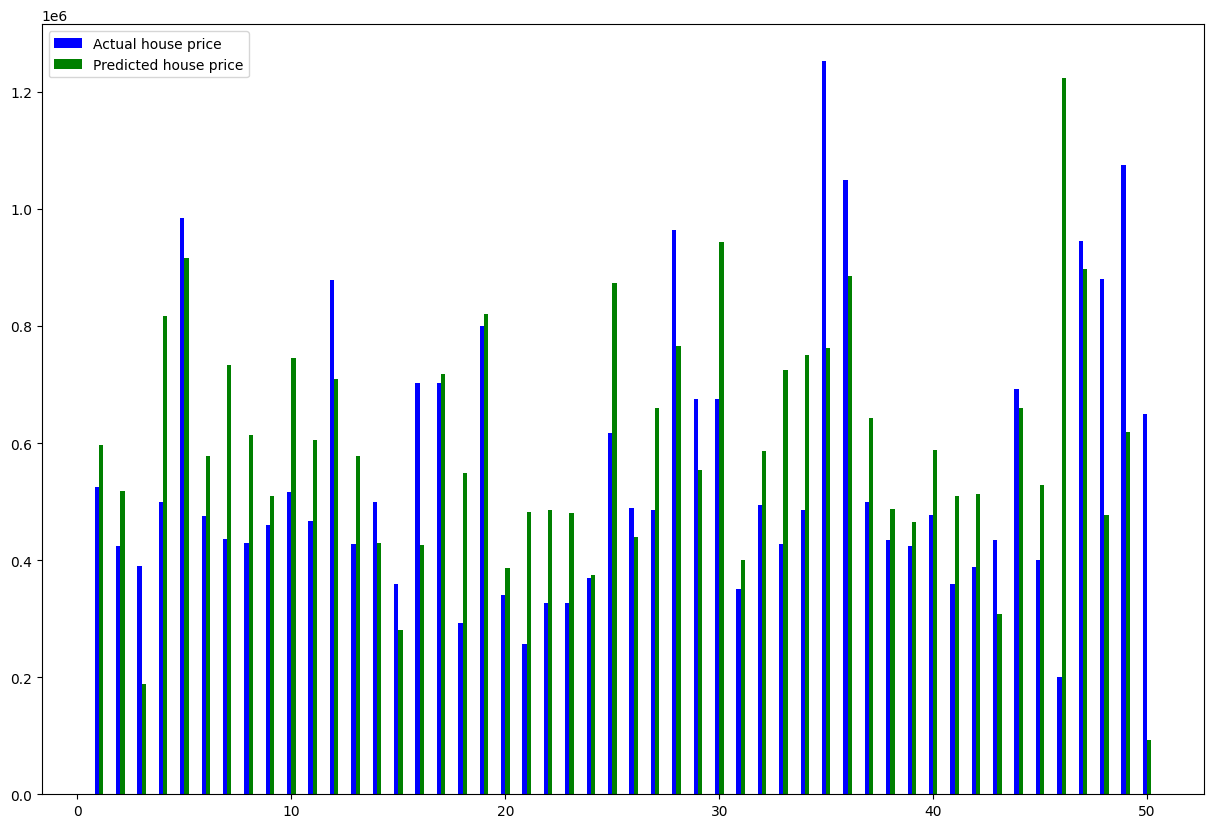

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.556
Model:                            OLS   Adj. R-squared (uncentered):              0.535
Method:                 Least Squares   F-statistic:                              26.91
Date:                Tue, 28 Nov 2023   Prob (F-statistic):                    2.79e-63
Time:                        10:37:28   Log-Likelihood:                         -6626.4
No. Observations:                 450   AIC:                                  1.329e+04
Df Residuals:                     430   BIC:                                  1.337e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [323]:
fitted_model = fit_model(houses_data)

In [306]:
make_prediction(fitted_model, cambridge_latitude, cambridge_longitude)

Predicted price - 0    2.698941e+08
dtype: float64


0    2.698941e+08
dtype: float64

## Large Language Models

If you used LLMs to generate or fix code in this assignment (recommended), briefly summarise the process and prompts you used. What do you think of the integration of LLMs in the data science pipeline?

I have been using LLMs while working towards solving this assignment. While initially I did try to run the agents as we need to lab 1, I did not find it easier to work with than compared to using it in the browser. 

The integration of LLMs in data science looks beneficial and inevitable, as you can spend more time focusing on the important difficult bits rather than knowing by heart how to use pandas, matplotlib, etc.

I have used LLMs when creating the MySQL queries and while combining question 2 OSM extra data into my dataframe from prices_coordinates_data table.

### FAQs

- Why is my connection to the AWS server intermittent?

If you are using Google Colab, online notebooks may throttle your code or time you out. Local Python code is recommended for tasks for large data management in the database.

- Why do SQL queries take a long time?

Some queries legitimately take a long time, even when done right. We suggest indexing your tables to speed up queries over your database. You can index tables by different columns depending on the queries you want to perform. For example, indexing the tables by `postcode` could speed up the join in Task D. More information regarding indexing in MariaDB is available [here](https://mariadb.com/kb/en/getting-started-with-indexes/).

You may also want to consider creating single or multi-column indices on coordinates, or any other properties you use to select data, if that step is taking a long time.

If your new queries seem stuck, try running `SHOW FULL PROCESSLIST`, and `KILL` any stuck processes.

- Why are table populating processes taking so long?

Again populating the database can take long. However, be careful if you are indexing the tables. You should populate data before indexing. Insert operations are impacted by indexes as they are updated with each new row inserted into the table.

- Some other questions are answered in [this reddit forum](https://www.reddit.com/r/CST_ADS/) or [this doc](https://docs.google.com/document/d/1GfDROyUW8HVs2eyxmJzKrYGRdVyUiVXzPcDfwOO8wX0/edit?usp=sharing). Feel free to also ask about anything that comes up.